# Abalone Age Calculator
Progetto di Programmazione di Applicazioni Data Intensive a.a. 2023/2024 \
Autore: Mattia Forti - mattia.forti2@studio.unibo.it \
Matricola: 0001021445

## Introduzione
AAC è un modello di predizione il cui obbiettivo è stimare l'età di un [abalone](https://it.wikipedia.org/wiki/Haliotis) in base a varie caratteristiche.

La normale pratica per sapere l'età di un abalone è la seguente:
1. Tagliare il guscio lungo il cono.
2. Applicare un colorante sull'area tagliata.
3. Contare il numero di anelli utilizzando un microscopio.

Il numero di anelli definisce l'età dell'abalone, perciò sarà questa la variabile da predire.

## Inizializzazione
Per iniziare dobbiamo importare le varie librerie che serviranno allo sviluppo del modello:
* *numpy* &rarr; analisi dei dati sotto forma di array.
* *pandas* &rarr; analisi dei dati sotto forma di tabelle.
* *pyplot* &rarr; rappresentazione dei dati in dei grafici.

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Successivamente procediamo ad importare il dataset preso da [UCI Machine Learning Archive](https://archive.ics.uci.edu/dataset/1/abalone) e guardiamo com'è strutturato.

In [92]:
import os.path
file = "abalone.data"
if not os.path.exists(file):
    print("Errore: file non trovato")
columns = ['Sesso', 'Lunghezza', 'Diametro', 'Altezza', 'Peso_Totale', 'Peso_Mollusco', 'Peso_Viscere', 'Peso_Guscio', 'Anelli']
abalones = pd.read_csv(file, names=columns)

In [93]:
abalones.info(verbose = False, memory_usage = "deep")
abalones.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Columns: 9 entries, Sesso to Anelli
dtypes: float64(7), int64(1), object(1)
memory usage: 497.8 KB


,Sesso,Lunghezza,Diametro,Altezza,Peso_Totale,Peso_Mollusco,Peso_Viscere,Peso_Guscio,Anelli
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Analisi dei Dati
Gli abaloni presentano le seguenti caratteristiche:
* `Sesso` &rarr; sesso dell'abalone, può essere M (Maschio), F (Femmina) o I (Infante).
* `Lunghezza` &rarr; lunghezza dell'abalone.
* `Diametro` &rarr; diametro dell'abalone.
* `Altezza` &rarr; altezza dell'abalone.
* `Peso_Totale` &rarr; peso di un abalone, ovvero compreso di guscio e mollusco vivo.
* `Peso_Mollusco` &rarr; peso del mollusco vivo.
* `Peso_Viscere` &rarr; peso delle viscere (senza sangue dentro) del mollusco.
* `Peso_Guscio` &rarr; peso del guscio.
* `Anelli` &rarr; anelli del guscio.

Andiamo a creare alcuni grafici per visualizzare meglio come sono distribuiti i dati.

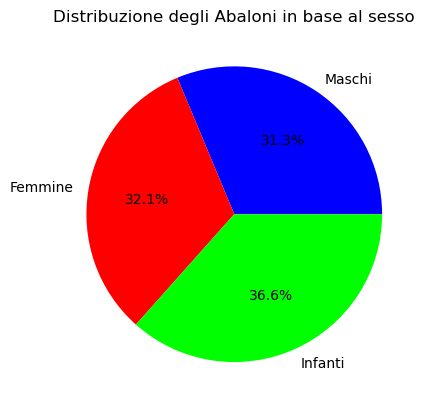

In [94]:
pie_values = abalones.groupby(by='Sesso')['Sesso'].value_counts()
plt.pie(pie_values, labels=['Maschi', 'Femmine', 'Infanti'], autopct='%2.1f%%', colors=['blue', 'red', 'lime'])
plt.title("Distribuzione degli Abaloni in base al sesso")
plt.show()

Il sesso è distribuito piuttosto ugualmente tra gli abaloni, adesso diamo un'occhiata agli anelli.

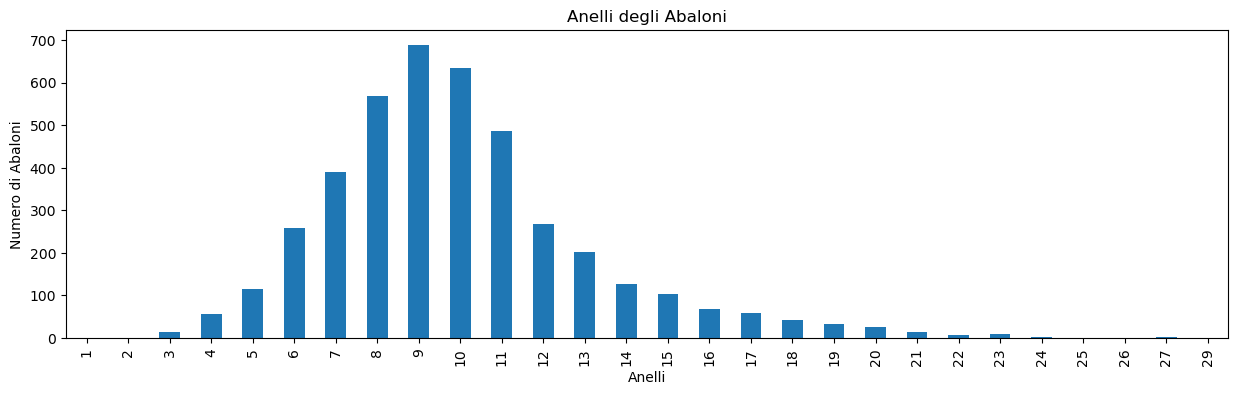

In [95]:
abalones['Anelli'].value_counts().sort_index().plot.bar(figsize=(15, 4))
plt.xlabel('Anelli')
plt.ylabel('Numero di Abaloni')
plt.title('Anelli degli Abaloni')
plt.show()

Notiamo che il numero di anelli varia da 1 a 29 e che la maggior parte degli abaloni possiedono tra 8 e 11 anelli.

Controlliamo anche alcune caratteristiche fisiche.

In [96]:
abalones['Lunghezza'].describe()

count    4177.000000
mean        0.523992
std         0.120093
min         0.075000
25%         0.450000
50%         0.545000
75%         0.615000
max         0.815000
Name: Lunghezza, dtype: float64

In [97]:
abalones['Altezza'].describe()

count    4177.000000
mean        0.139516
std         0.041827
min         0.000000
25%         0.115000
50%         0.140000
75%         0.165000
max         1.130000
Name: Altezza, dtype: float64

In [98]:
abalones['Diametro'].describe()

count    4177.000000
mean        0.407881
std         0.099240
min         0.055000
25%         0.350000
50%         0.425000
75%         0.480000
max         0.650000
Name: Diametro, dtype: float64

In [99]:
abalones['Peso_Totale'].describe()

count    4177.000000
mean        0.828742
std         0.490389
min         0.002000
25%         0.441500
50%         0.799500
75%         1.153000
max         2.825500
Name: Peso_Totale, dtype: float64

In [100]:
abalones['Anelli'].describe()

count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: Anelli, dtype: float64

Notiamo che in alcuni parametri il valore minimo e il valore massimo sono molto distaccati, ma comunque la media rimane in mezzo ai due, infatti le deviazioni standard dei parametri sono tutte molto basse.

L'unica che si distingue dalle altre è quella degli anelli, perciò possiamo già aspettarci delle imprecisioni di calcolo nei modelli che costruiremo.

## Preparazione dei Dati
Prima di cominciare a creare dei modelli e a testarli dobbiamo rielaborare i dati, ovvero:
* Rimuovere valori nulli o inutili.
* Verificare la correlazione tra le feature.
* Selezionare/Modificare le feature rilevanti.

### Eliminazione di valori nulli

In [101]:
abalones.isna().sum()

Sesso            0
Lunghezza        0
Diametro         0
Altezza          0
Peso_Totale      0
Peso_Mollusco    0
Peso_Viscere     0
Peso_Guscio      0
Anelli           0
dtype: int64

Non esistono righe con dati nulli e tutti parametri presenti nel dataset sono utili alla predizione dell'età degli abaloni, perciò non è necessario eliminare niente.

### Correlazione tra Feature
Il parametro da predire è il numero di anelli, andiamo quindi a vedere se i parametri influiscono su di esso e viceversa.

In [102]:
abalones.drop(columns=['Sesso']).corr()

,Lunghezza,Diametro,Altezza,Peso_Totale,Peso_Mollusco,Peso_Viscere,Peso_Guscio,Anelli
Lunghezza,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diametro,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Altezza,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Peso_Totale,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Peso_Mollusco,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Peso_Viscere,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Peso_Guscio,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Anelli,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


Come potevamo aspettarci, i parametri hanno un'influenza piuttosto significativa tra di loro, questo perché sono caratteristiche fisiche, perciò è normale che più un abalone è grande di dimensioni, più è probabile che sia vecchio.

Proviamo quindi a visualizzare queste correlazioni con dei grafici.

In [103]:
def scatter_plot(df, feature):
    avg_rings = {}
    min = int(df[feature].min() * 1000)
    max = int(df[feature].max() * 1000)
    weight_range = [x / 1000 for x in range(min, max)]
    for i in weight_range:
        avg_rings[i] = df[df[feature]==i]['Anelli'].mean()
    avg_rings = pd.Series(avg_rings)
    plt.xlabel(feature)
    plt.ylabel("Anelli")
    plt.scatter(avg_rings.index, avg_rings)

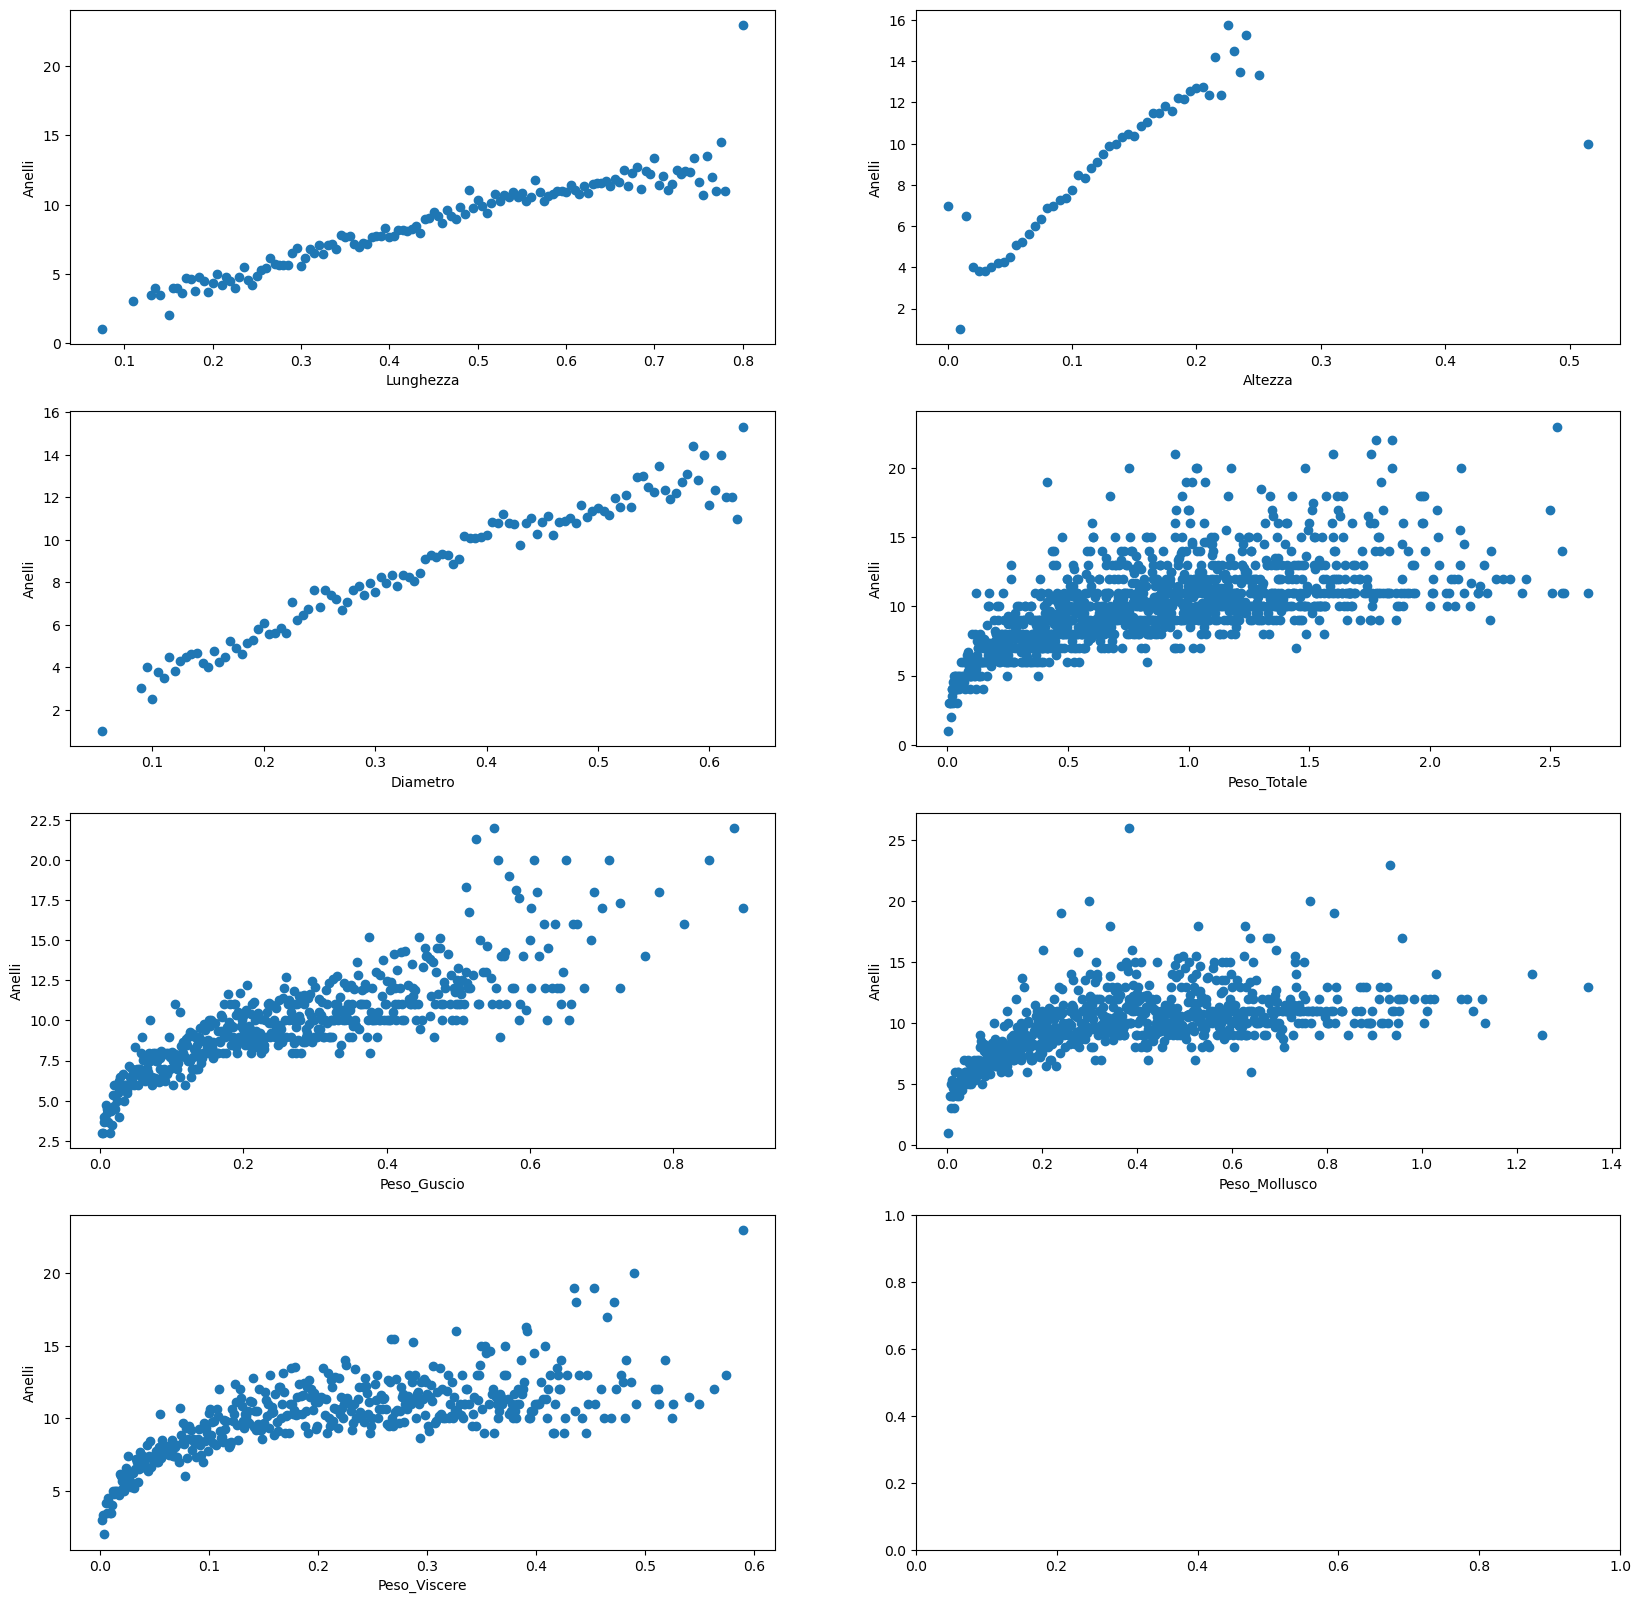

In [104]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False, figsize=(20, 20))
plt.subplot(4, 2, 1)
scatter_plot(abalones, 'Lunghezza')
plt.subplot(4, 2, 2)
scatter_plot(abalones, 'Altezza')
plt.subplot(4, 2, 3)
scatter_plot(abalones, 'Diametro')
plt.subplot(4, 2, 4)
scatter_plot(abalones, 'Peso_Totale')
plt.subplot(4, 2, 5)
scatter_plot(abalones, 'Peso_Guscio')
plt.subplot(4, 2, 6)
scatter_plot(abalones, 'Peso_Mollusco')
plt.subplot(4, 2, 7)
scatter_plot(abalones, 'Peso_Viscere')

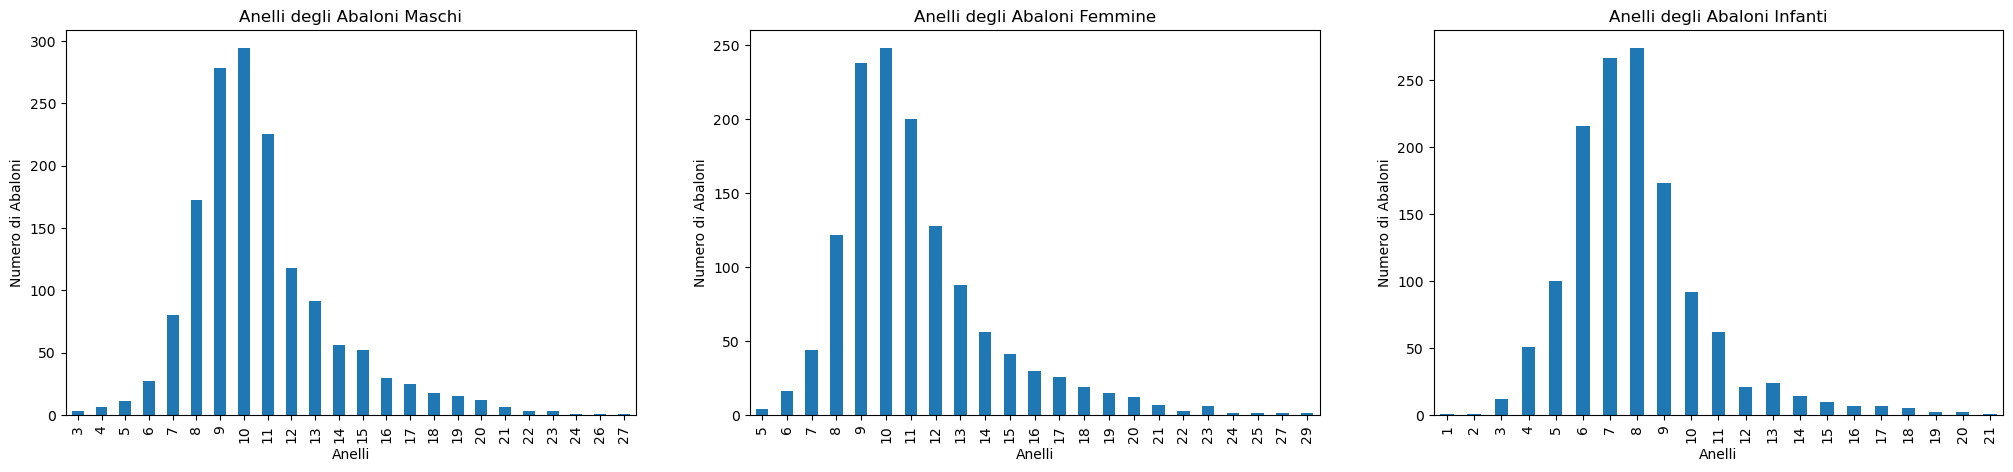

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False)

male_abalones = abalones.loc[abalones['Sesso'] == 'M']
female_abalones = abalones.loc[abalones['Sesso'] == 'F']
infant_abalones = abalones.loc[abalones['Sesso'] == 'I']

plt.subplot(1, 3, 1)
male_abalones['Anelli'].value_counts().sort_index().plot.bar(figsize=(25,5))
plt.xlabel('Anelli')
plt.ylabel('Numero di Abaloni')
plt.title('Anelli degli Abaloni Maschi')

plt.subplot(1, 3, 2)
female_abalones['Anelli'].value_counts().sort_index().plot.bar(figsize=(25,5))
plt.xlabel('Anelli')
plt.ylabel('Numero di Abaloni')
plt.title('Anelli degli Abaloni Femmine')

plt.subplot(1, 3, 3)
infant_abalones['Anelli'].value_counts().sort_index().plot.bar(figsize=(25,5))
plt.xlabel('Anelli')
plt.ylabel('Numero di Abaloni')
plt.title('Anelli degli Abaloni Infanti')

plt.show()

I grafici mostrano come il sesso degli abaloni non abbia una grande influenza sul numero di anelli. Gli infanti ovviamente hanno in media un numero minore di anelli, appunto perché sono più giovani.

### Selezione/Modifica delle Feature Rilevanti
Abbiamo appena visto che il sesso non influisce sugli abaloni adulti, perciò possiamo unire le due categorie in una sola, convertendo quindi la colonna *Sesso* nella colonna *Adulto*, che rappresenterà un valore 1 o 0 in base a se l'abalone è adulto o infante.

In [106]:
abalones['Sesso'] = abalones['Sesso'].replace('M', 1)
abalones['Sesso'] = abalones['Sesso'].replace('F', 1)
abalones['Sesso'] = abalones['Sesso'].replace('I', 0)
abalones.rename(columns={'Sesso': 'Adulto'}, inplace=True)
abalones.head()

,Adulto,Lunghezza,Diametro,Altezza,Peso_Totale,Peso_Mollusco,Peso_Viscere,Peso_Guscio,Anelli
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Come visto nei grafici, alcuni abaloni presentano delle caratteristiche molto diverse dagli altri, perciò rimuoviamo gli estremi per bilanciare il dataset.

In [107]:
abalones = abalones.loc[abalones['Lunghezza'] < 0.78]
abalones = abalones.loc[abalones['Altezza'] < 0.3]
abalones = abalones.loc[abalones['Peso_Totale'] < 2.25]
abalones = abalones.loc[abalones['Peso_Guscio'] < 0.8]
abalones = abalones.loc[abalones['Peso_Mollusco'] < 1.1]
abalones = abalones.loc[abalones['Peso_Viscere'] < 0.52]

## Creazione di un modello
Cominciamo con il definire i training sets e i testing sets, utilizzando la funzione `train_test_split()` della libreria `sklearn`.

In [108]:
from sklearn.model_selection import train_test_split
import scipy.sparse

X = abalones.drop(columns=['Anelli'])
y = abalones['Anelli']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)
X_test_sparse = scipy.sparse.csr_matrix(X_test.values)

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
# Sopprimiamo i warning della GridSearch
warnings.filterwarnings("ignore")

### Regressione Lasso
Il primo modello da testare è il Lasso, lo utilizziamo per estrarre le feature più importanti da selezionare per i modelli successivi.

In [110]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale",  StandardScaler(with_mean=False)),
    ("linreg", Lasso())
])
grid = {
    "linreg__alpha": [x/100 for x in range(1, 10)]
}
gs = GridSearchCV(model, param_grid=grid, return_train_score=True)
gs.fit(X_train_sparse, y_train)
print("Accuratezza: ", gs.score(X_train_sparse, y_train) * 100, '%')
sel = ["rank_test_score", "mean_test_score", "mean_train_score", "params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

Accuratezza:  52.97538612091947 %


,rank_test_score,mean_test_score,mean_train_score,params
0,1,0.526513,0.529969,{'linreg__alpha': 0.01}
1,2,0.520285,0.523685,{'linreg__alpha': 0.02}
2,3,0.513598,0.516865,{'linreg__alpha': 0.03}
3,4,0.511160,0.514387,{'linreg__alpha': 0.04}
4,5,0.508982,0.512254,{'linreg__alpha': 0.05}
5,6,0.506316,0.509632,{'linreg__alpha': 0.06}
6,7,0.503169,0.506532,{'linreg__alpha': 0.07}
7,8,0.499539,0.502952,{'linreg__alpha': 0.08}
8,9,0.495427,0.498895,{'linreg__alpha': 0.09}


Prendiamo il parametro più piccolo ed utilizziamolo come valore alpha per allenare un modello che estrarrà le feature più importanti.

In [111]:
model = Pipeline([
    ("scale",  StandardScaler(with_mean=False)),
    ("linreg", Lasso(alpha=0.01))
])
model.fit(X_train, y_train);
lasso = pd.Series(model.named_steps["linreg"].coef_, X.columns)
c = len(lasso[lasso>0])
print("Features estratte: "+ str(c))
lasso[lasso>0].sort_values(ascending=False)

Features estratte: 5


Peso_Totale    2.419715
Peso_Guscio    1.498502
Altezza        0.880713
Diametro       0.723759
Adulto         0.370660
dtype: float64

Vediamo che il peso totale e il peso del guscio sono estremamente influenti, subito dopo ci sono l'altezza, il diametro e, come potevamo aspettarci, il parametro che indica se l'abalone è adulto.

### Regressione Ridge

In [112]:
from sklearn.linear_model import Ridge
model = Pipeline([
    ("scale",  StandardScaler(with_mean=False)),
    ("linreg", Ridge())
])
grid = {
    "linreg__alpha": [0.01, 0.1, 1, 5, 10, 50]
}
gs = GridSearchCV(model, param_grid=grid, cv=5, return_train_score=True)
gs.fit(X_train_sparse, y_train)
print("Accuratezza: ", gs.score(X_train_sparse, y_train) * 100, '%')
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

Accuratezza:  53.18299048000845 %


,rank_test_score,mean_test_score,mean_train_score,params
2,1,0.527591,0.532130,{'linreg__alpha': 1}
1,2,0.527540,0.532186,{'linreg__alpha': 0.1}
0,3,0.527529,0.532187,{'linreg__alpha': 0.01}
3,4,0.527014,0.531247,{'linreg__alpha': 5}
4,5,0.525667,0.529701,{'linreg__alpha': 10}
5,6,0.516239,0.519858,{'linreg__alpha': 50}


Modificando il peso della regolarizzazione (alpha) non c'è una differenza significativa tra i risultati, che sono molto simili a quelli della Regressione Lasso.

Anche qui l'accuratezza è soltanto 53%, il motivo è che le feature sono fortemente correlate, perciò anche utilizzando diversi parametri di alpha il risultato non cambia di molto. 

### Regressione Lineare

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

linear_model = Pipeline([
    ("scale",  StandardScaler(with_mean=False)),
    ("linreg", LinearRegression())
])

kf = KFold(5, shuffle=True, random_state=42)
scores = cross_val_score(model,X_train_sparse, y_train, cv=kf)
print("Accuratezza: ", scores.mean() * 100, '%')

Accuratezza:  52.66765328357088 %


Anche qui l'accuratezza rimane attorno al 52% a causa della distribuzione dei dati, infatti nei grafici abbiamo visto che sono molto differenziati, ma seguono una larga curva, perciò successivamente andremo a testare una regressione polinomiale.

### Regressione non Lineare

I metodi precedenti non sono stati sufficienti a ottenere dei risultati soddisfacenti, proviamo ad utilizzare una regressione polinomiale per migliorare la curva che rappresenterà le predizioni del nostro modello.

In [135]:
from sklearn.preprocessing import PolynomialFeatures
reduced_model = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler(with_mean=False)),
    ("linreg", Ridge())
])
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=1/3, random_state=42)
grid = {
    "poly__degree": [2, 3, 4],
    "linreg__alpha": [0.1, 1, 10]
    }
gs = GridSearchCV(reduced_model, param_grid=grid, return_train_score=True)
gs.fit(train_x, train_y)
print("Accuratezza: ", gs.score(X_test_sparse, y_test) * 100, '%')
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

Accuratezza:  59.48835783367967 %


,rank_test_score,mean_test_score,mean_train_score,params
3,1,0.562161,0.577161,"{'linreg__alpha': 1, 'poly__degree': 2}"
0,2,0.558715,0.582530,"{'linreg__alpha': 0.1, 'poly__degree': 2}"
6,3,0.556201,0.565084,"{'linreg__alpha': 10, 'poly__degree': 2}"
7,4,0.555516,0.573140,"{'linreg__alpha': 10, 'poly__degree': 3}"
4,5,0.551526,0.585388,"{'linreg__alpha': 1, 'poly__degree': 3}"
8,6,0.547124,0.580378,"{'linreg__alpha': 10, 'poly__degree': 4}"
1,7,0.539041,0.595421,"{'linreg__alpha': 0.1, 'poly__degree': 3}"
5,8,0.534322,0.593357,"{'linreg__alpha': 1, 'poly__degree': 4}"
2,9,0.520686,0.607694,"{'linreg__alpha': 0.1, 'poly__degree': 4}"


L'accuratezza è migliorata, ma non di molto. Come avevamo visto in precedenza, la deviazione degli anelli è piuttosto alta, questo influisce sui risultati del modello, ma proviamo a visualizzare dei grafici per capire come si sta effettivamente comportando.

In [114]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def get_errors(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    return mse, re * 100, r2

def plot_model_on_data(X, y, model=None):
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_x_df = pd.DataFrame(line_x[:, None], columns=X.columns)
        line_y = model.predict(line_x_df)
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim)
        plt.ylim(ylim)
    plt.grid()

In [115]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def get_train_sets(feature, training_set):
    return train_test_split(training_set[[feature]], training_set['Anelli'], test_size=1/3, random_state=42)

prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=3, include_bias=False)),
    ("linreg", LinearRegression())
])

In [116]:
def show_plot(training_sets, features=['Lunghezza', 'Altezza', 'Diametro', 'Peso_Totale'], figsize=(20, 20)):
    i = 1
    j = 1
    fig, axes = plt.subplots(nrows=len(features), ncols=len(training_sets), sharex=False, sharey=False, figsize=figsize)
    if (len(training_sets) == 2):
        axes[0,0].set_title('Adulti')
        axes[0,1].set_title('Infanti')
    fig.tight_layout()
    data = {
        'Parametro': features,
        'MSE': np.zeros(len(features)),
        'RE': np.zeros(len(features)),
        'R2': np.zeros(len(features))
    }
    errors = {}
    for df in training_sets:
        j = i
        errors_df = pd.DataFrame(data)
        for feature in features:
            plt.subplot(len(features), len(training_sets), j)
            X_train, X_test, y_train, y_test = get_train_sets(feature, df)
            prm.fit(X_train, y_train)
            plot_model_on_data(X_test, y_test, prm)
            j+=len(training_sets)
            errors_df.loc[errors_df['Parametro'] == feature, ['MSE', 'RE', 'R2']] = get_errors(X_test, y_test, prm)
            plt.xlabel(feature)
            plt.ylabel("Anelli")
        errors[i-1] = errors_df
        i+=1
    if (len(training_sets) > 1):
        return pd.concat(errors, axis=1)
    else:
        return errors[0]

,Parametro,MSE,RE,R2
0,Lunghezza,7.451652,19.049063,0.320871
1,Altezza,6.927186,18.633921,0.368670
2,Diametro,7.268966,18.732169,0.337520
3,Peso_Totale,7.164368,18.753262,0.347053


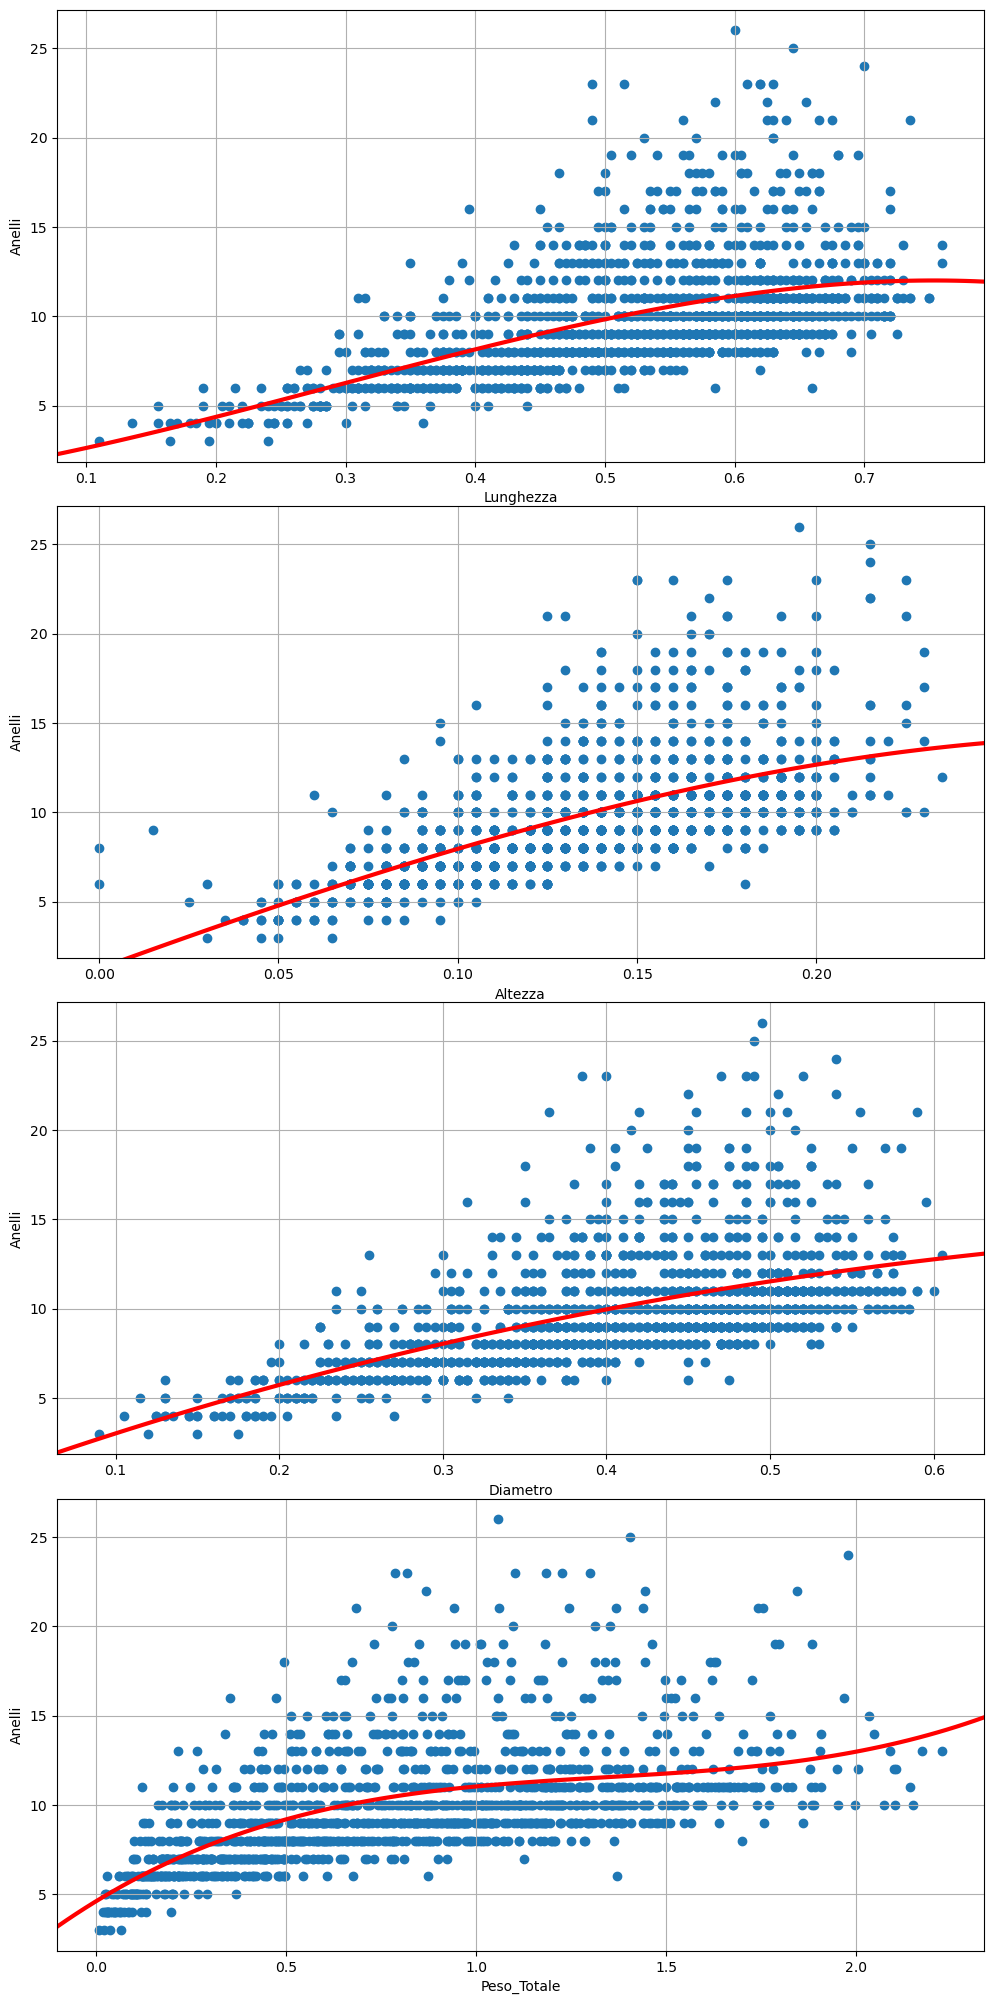

In [117]:
show_plot([abalones], figsize=(10, 20))

Notiamo che il nostro modello ha fatto delle buone predizioni, ma a causa della dispersione dei dati il modello rileva che non è stato molto preciso, mostrando un errore del 19%.

Siccome gli abaloni adulti hanno delle caratteristiche molto diversificate, proviamo a dividere gli adulti dagli infanti e confrontiamoli.

Adulti                                     Infanti            \
     Parametro       MSE         RE        R2    Parametro       MSE   
0    Lunghezza  7.904053  19.767985  0.118831    Lunghezza  3.660335   
1      Altezza  7.301890  18.873083  0.185963      Altezza  3.335366   
2     Diametro  7.739123  19.597490  0.137218     Diametro  3.616216   
3  Peso_Totale  7.716189  19.816205  0.139775  Peso_Totale  3.452188   

                        
          RE        R2  
0  15.340870  0.459715  
1  15.250668  0.507683  
2  15.177858  0.466228  
3  15.355742  0.490439

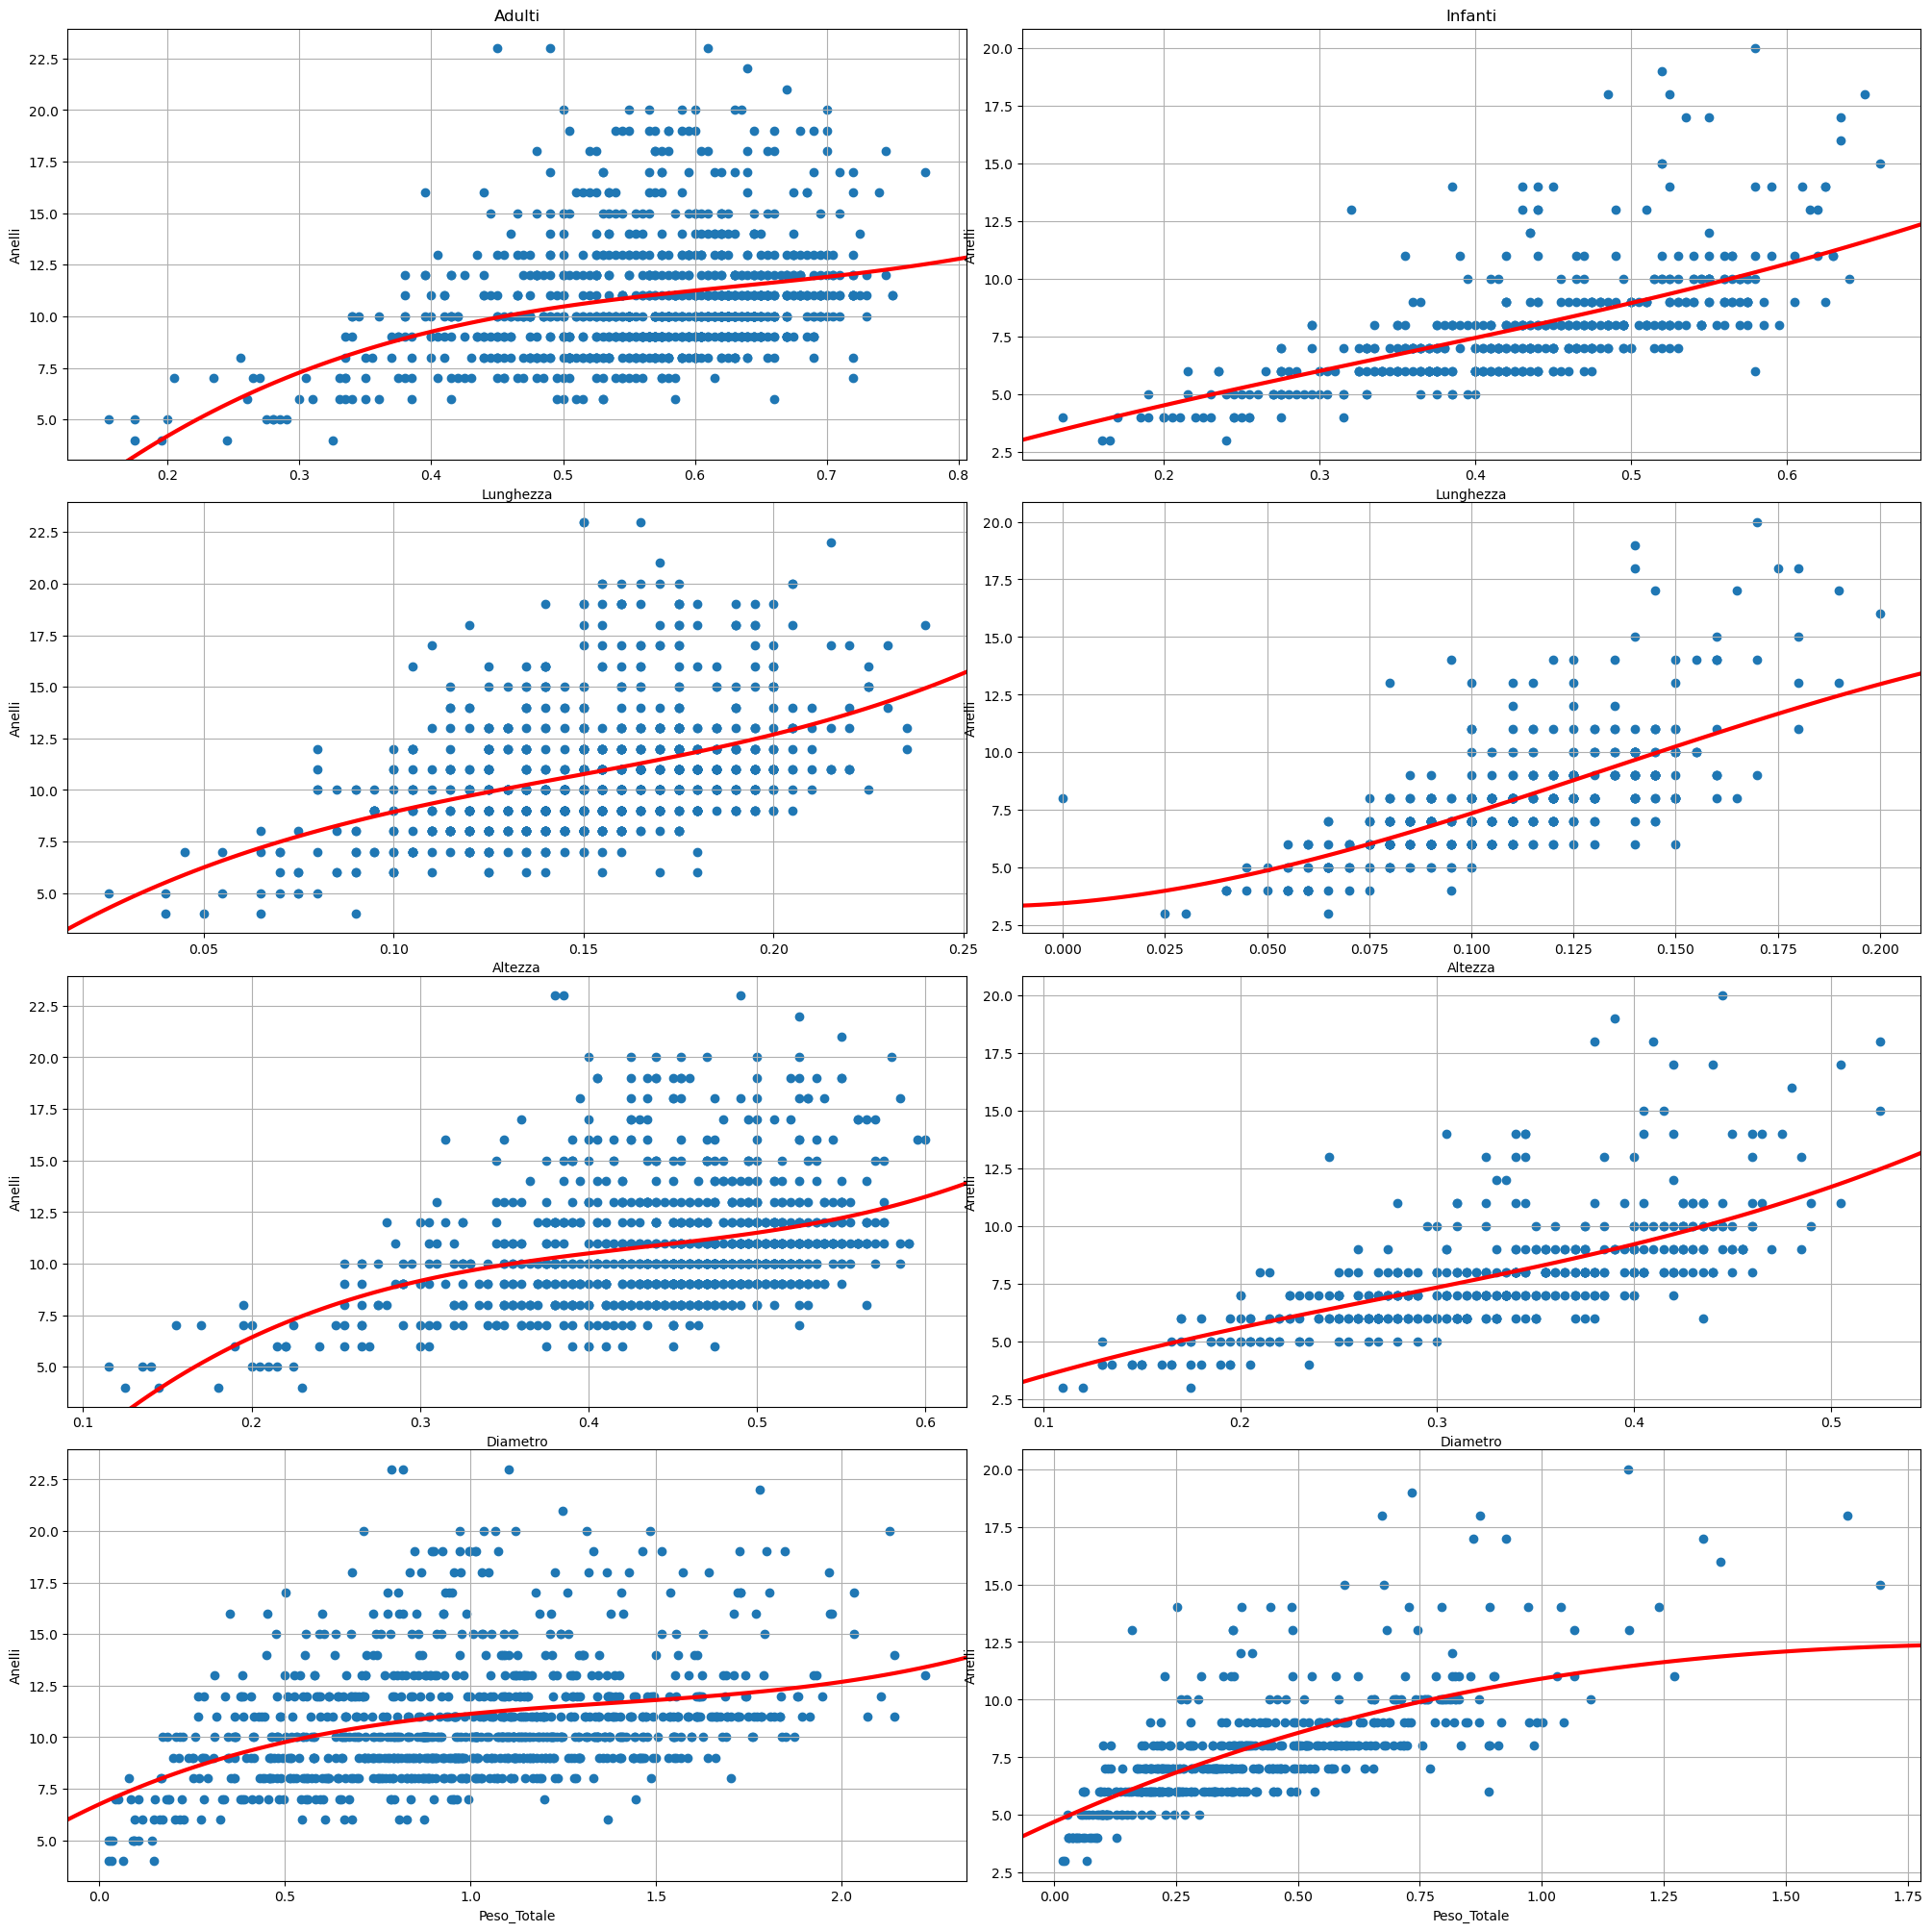

In [118]:
abalones_adults = abalones.loc[abalones['Adulto'] == True]
abalones_infants = abalones.loc[abalones['Adulto'] == False]
df = show_plot([abalones_adults, abalones_infants])
df.columns = df.columns.set_levels(['Adulti', 'Infanti'], level=0)
df

Con gli abaloni adulti infatti l'errore è rimasto a 19%, mentre per gli infanti è sceso a 15%.

Proviamo a ridurre ancora un po' i dati, eliminando gli abaloni molto vecchi e quelli molto giovani.

,Parametro,MSE,RE,R2
0,Lunghezza,3.151030,14.817895,0.273999
1,Altezza,2.945082,14.341375,0.321450
2,Diametro,3.087490,14.550694,0.288639
3,Peso_Totale,3.065834,14.585857,0.293628


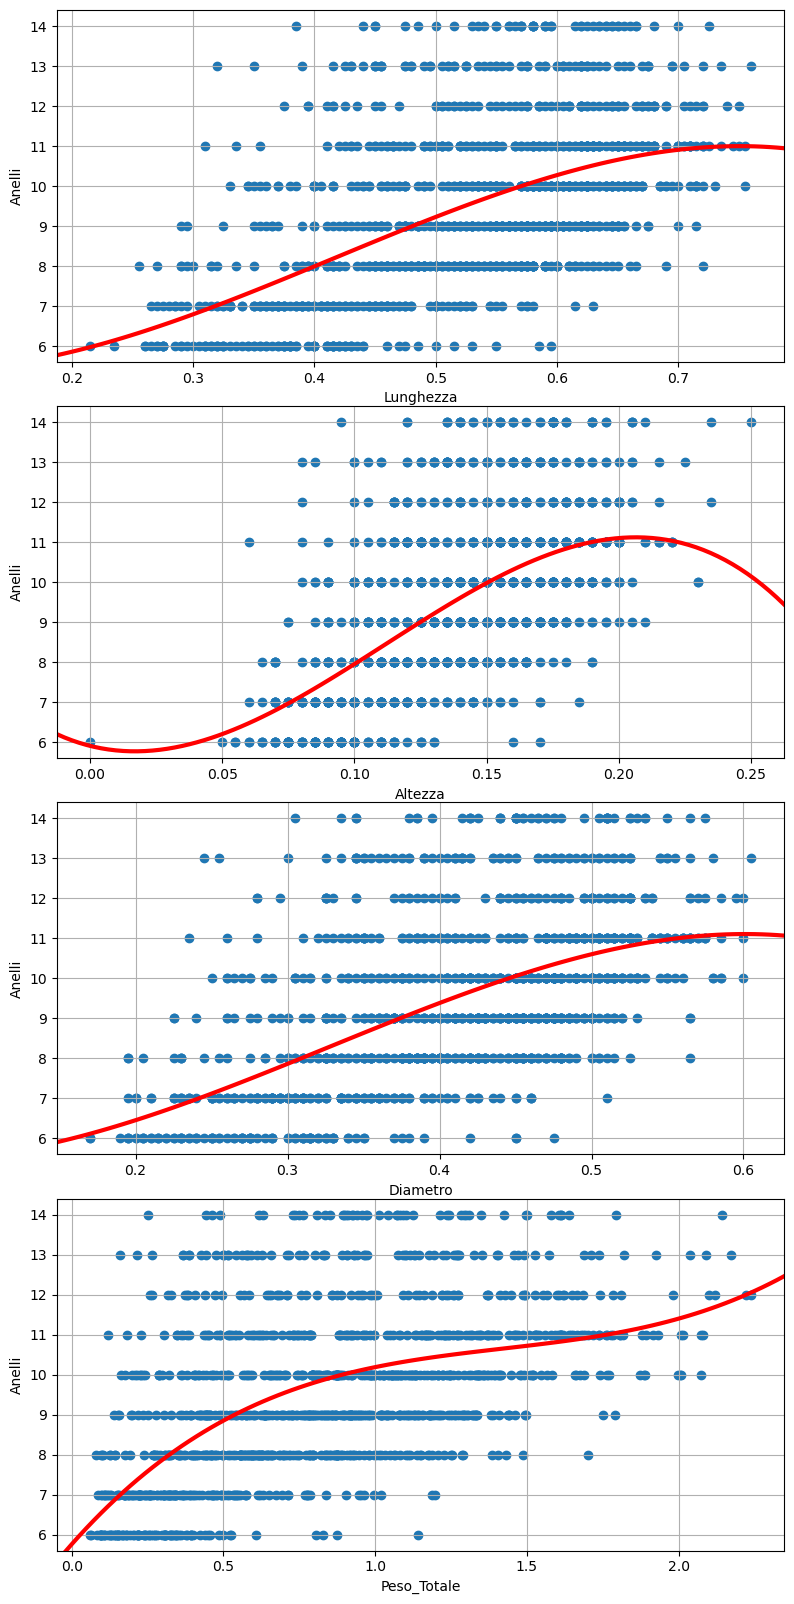

In [119]:
abalones_train = abalones.loc[abalones['Anelli'] < 15]
abalones_train = abalones_train.loc[abalones_train['Anelli'] > 5]
show_plot([abalones_train], figsize=(8, 16))

Vediamo come riducendo la distribuzione degli anelli i risultati migliorano, riducendo l'errore a 14%.

Questo test è però fatto su tutti gli abaloni, proviamo quindi a rifarlo dividendo nuovamente gli adulti dagli infanti e confrontiamoli.

Adulti                                     Infanti            \
     Parametro       MSE         RE        R2    Parametro       MSE   
0    Lunghezza  3.117928  14.627563  0.111541    Lunghezza  1.964885   
1      Altezza  3.046185  14.430408  0.131985      Altezza  1.890426   
2     Diametro  3.058203  14.487256  0.128560     Diametro  1.909925   
3  Peso_Totale  3.105341  14.651651  0.115128  Peso_Totale  1.878788   

                        
          RE        R2  
0  12.066984  0.375198  
1  12.299677  0.398875  
2  11.843047  0.392674  
3  11.838776  0.402575

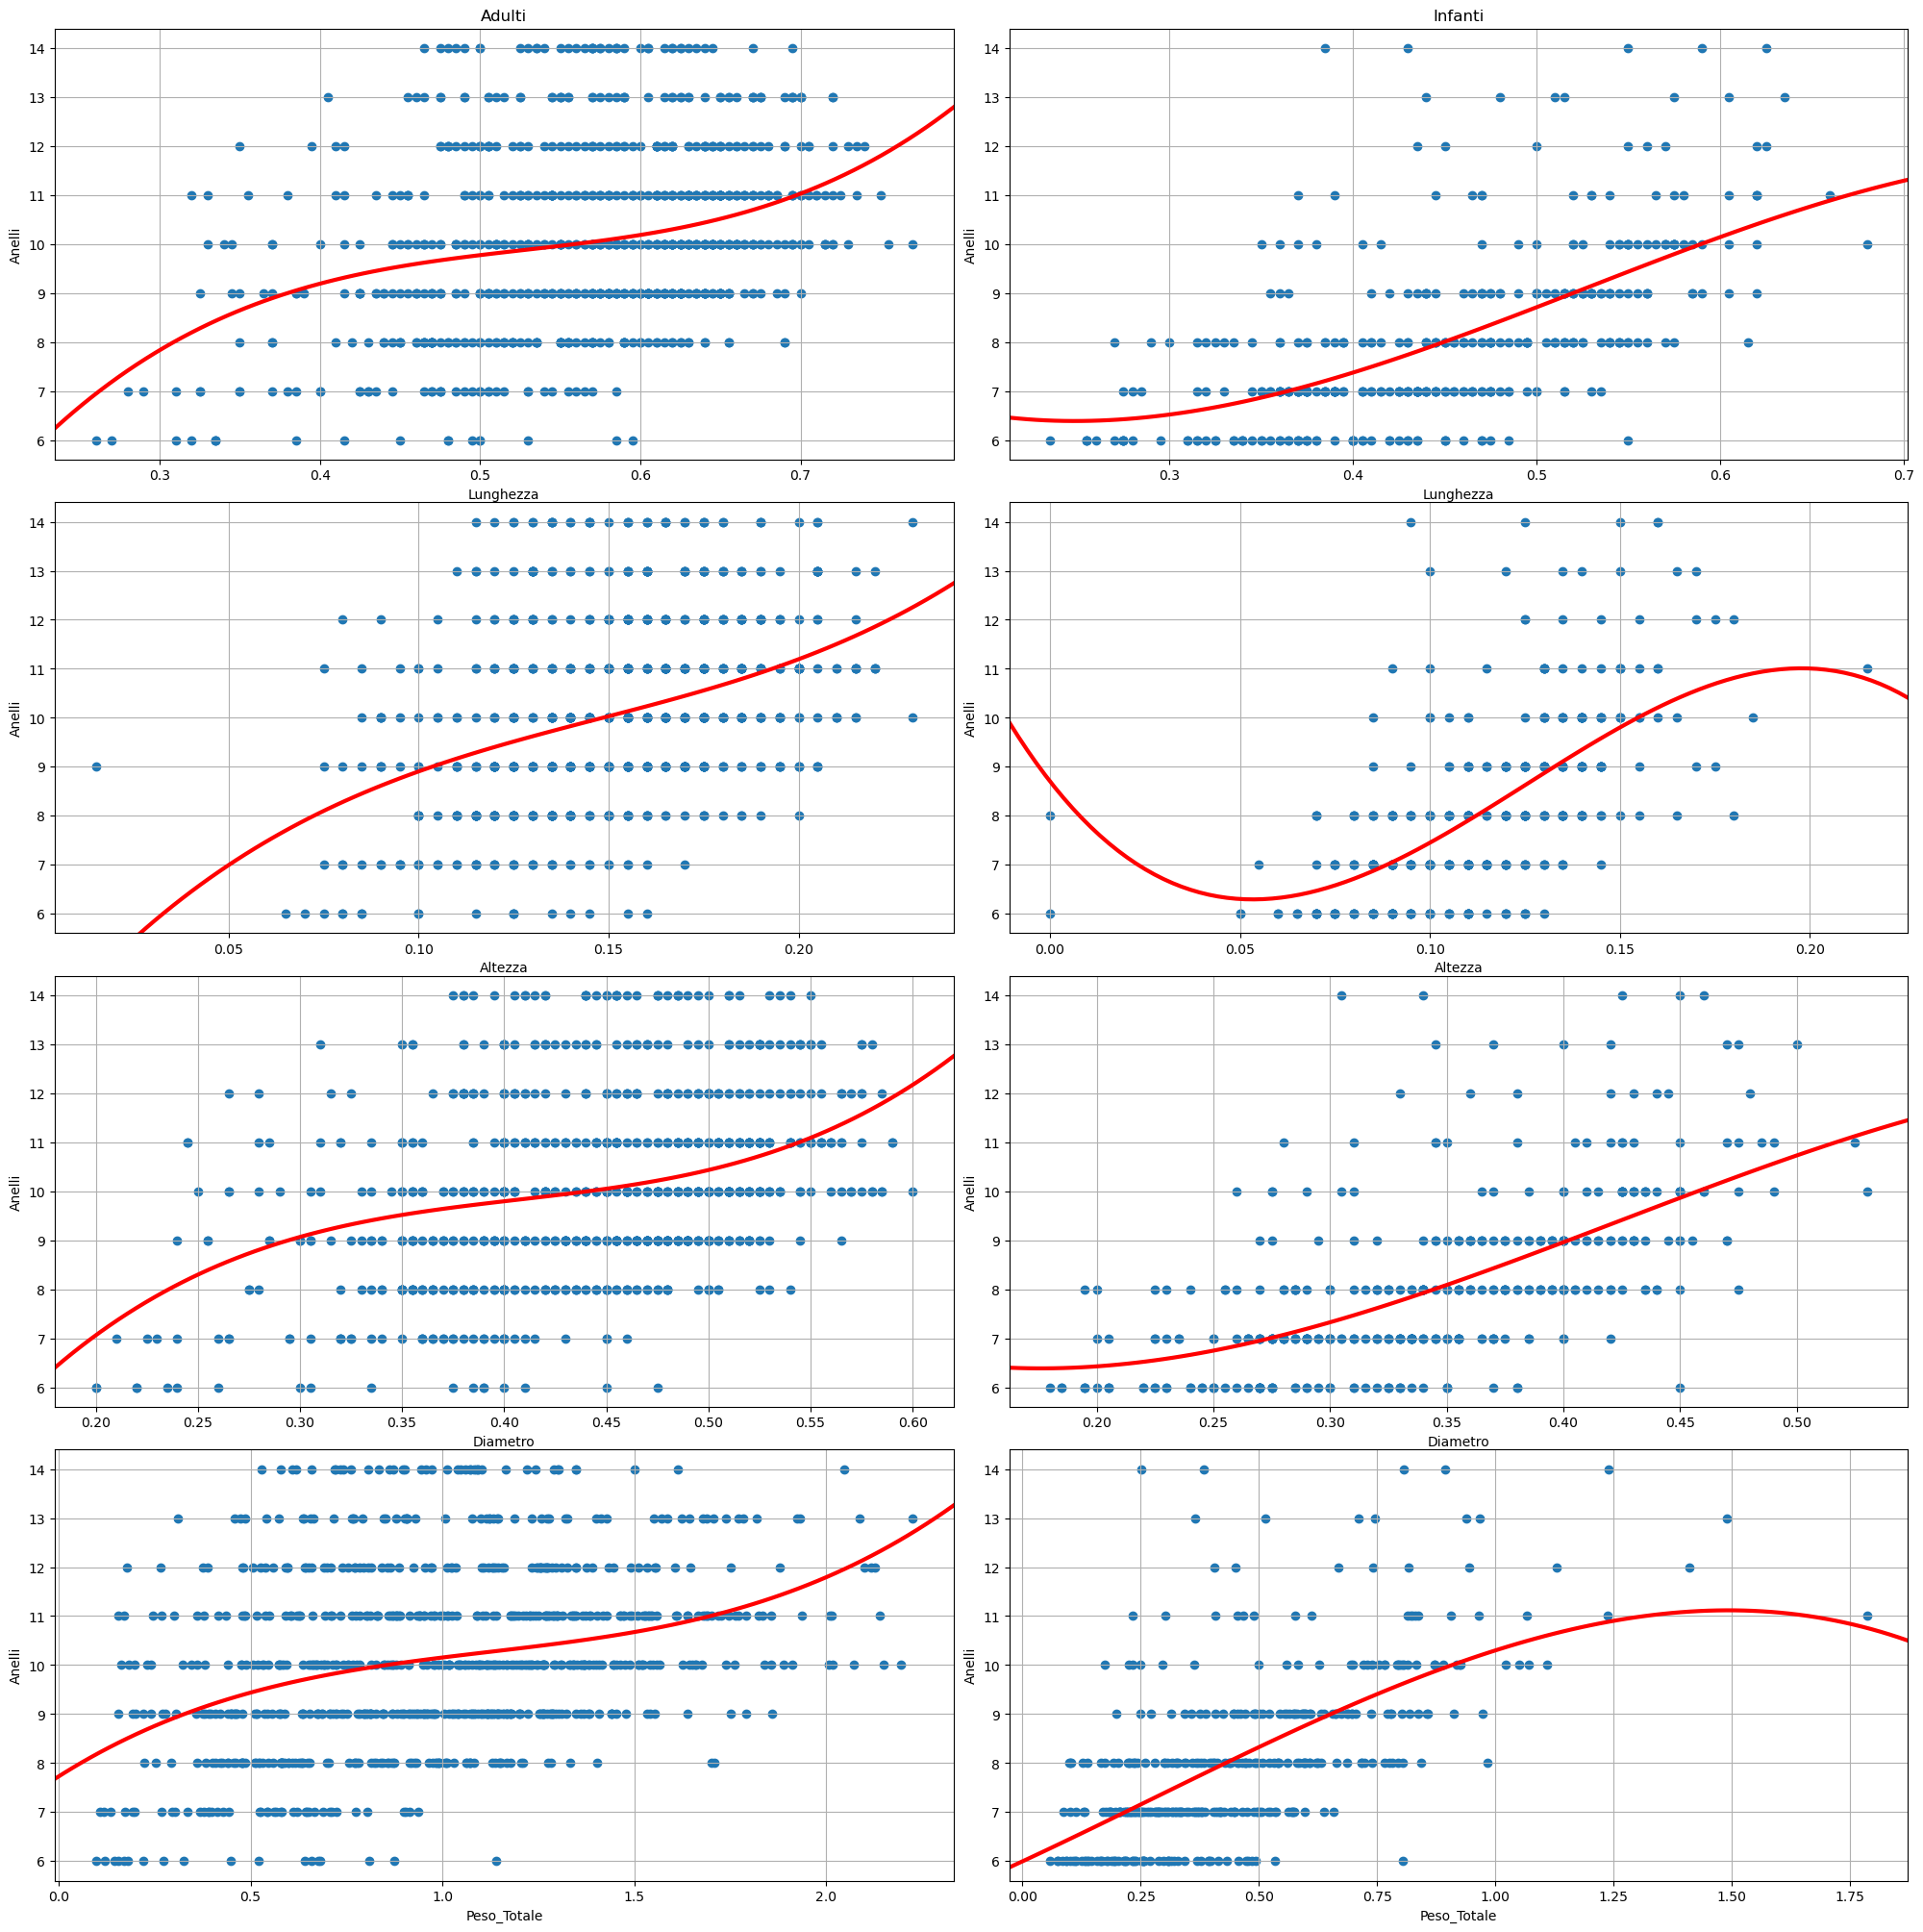

In [120]:
abalones_train_rings = abalones.loc[abalones['Anelli'] < 15]
abalones_train_rings = abalones_train_rings.loc[abalones_train_rings['Anelli'] > 5]

abalones_train_adults = abalones_train_rings.loc[abalones_train_rings['Adulto'] == True]
abalones_train_infants = abalones_train_rings.loc[abalones_train_rings['Adulto'] == False]

df = show_plot([abalones_train_adults, abalones_train_infants])
df.columns = df.columns.set_levels(['Adulti', 'Infanti'], level=0)
df

L'errore nelle valutazioni che utilizzano il peso totale e il diametro è sceso fino all'11% negli infanti.

Ulteriori tagli nel dataset rischiano di peggiorare le prestazioni in quanto avremmo troppi pochi dati.

## Conclusioni
Abbiamo visto come un modello di regressione polinomiale è il migliore per predire gli anelli di un abalone, ma con una precisione soltanto intorno al 60%. La bassa precisione è dovuta al fatto che i dati sono distribuiti in un range piuttosto ampio e con una deviazione standard altrettanto alta.

La distribuzione della target feature ha contribuito all'aumento degli errori, che siamo riusciti a quasi dimezzare separando i dati. Infatti abbiamo notato che gli abaloni adulti hanno delle caratteristiche molto più differenziate rispetto agli infanti.

## Considerazioni Personali
Il dataset è stato facile da analizzare perché le caratteristiche erano fortemente correlate e dai grafici sembrava che un modello di regressione lineare sarebbe stato sufficiente a fare delle buone predizioni.

Quando sono passato alla creazione e analisi dei modelli mi sono reso conto invece che queste correlazioni, insieme alla distribuzione dei dati, causavano diverse imprecisioni nelle valutazioni dei modelli. Andando però a vedere i grafici delle predizioni rispetto ai dati reali ho notato che il modello era concettualmente corretto, ma l'errore era inevitabile.